# **Text Classification by Fine-tuning Language Model**

# **1. Data Loading**

In [ ]:
!pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Install simpletransformers package
!pip install simpletransformers

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (replace with your dataset path)
data = pd.read_csv('/content/NLP dataset.csv')

# Rename columns to match the expected format
data = data.rename(columns={'Summary': 'text', 'Sentiment': 'label'})

# Exploratory Data Analysis (EDA)
print(data.info())  # Overview of data structure
print(data['label'].value_counts())  # Class distribution

# Split dataset into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

# Preparing the data in the correct format for SimpleTransformers
train_df = pd.DataFrame({
    'text': train_data['text'],
    'labels': train_data['label']
})

val_df = pd.DataFrame({
    'text': val_data['text'],
    'labels': val_data['label']
})

# Display the first few rows of the training and validation data
print("Training Data:")
print(train_df.head())

print("\nValidation Data:")
print(val_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    852 non-null    object
 1   label   852 non-null    object
dtypes: object(2)
memory usage: 13.4+ KB
None
label
positive    284
negative    284
neutral     284
Name: count, dtype: int64
Training Data:
                                                  text    labels
28       There’s a lot of bureaucracy slowing us down.  negative
664  Mandatory office days each week feel restrictive.  negative
193                Too many tasks come up last minute.  negative
404   I’m neutral about the new peer review mechanism.   neutral
465  I appreciate the extra day off provided last q...  positive

Validation Data:
                                                  text    labels
66               I feel a sense of purpose in my role.  positive
434  I’m on the fence about the newly introduced hy...   neutral
198  The

# **2. Text Preprocessing**

In [ ]:
import re

# Define a function to clean text data
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = text.strip()

    return text

# Apply the cleaning function to the dataset
train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)

# Display the first few rows of the cleaned training data
print("Cleaned Training Data:")
print(train_df.head())

# Display the first few rows of the cleaned validation data
print("\nCleaned Validation Data:")
print(val_df.head())

Cleaned Training Data:
                                                  text    labels
28         theres a lot of bureaucracy slowing us down  negative
664   mandatory office days each week feel restrictive  negative
193                 too many tasks come up last minute  negative
404     im neutral about the new peer review mechanism   neutral
465  i appreciate the extra day off provided last q...  positive

Cleaned Validation Data:
                                                  text    labels
66                i feel a sense of purpose in my role  positive
434  im on the fence about the newly introduced hyb...   neutral
198   the feedback culture here is great for my growth  positive
212  i have no strong view on the new project manag...   neutral
651  the robust training modules make me more confi...  positive


# **3. Text Embedding using BERT and RoBERTa**

In [ ]:
from simpletransformers.classification import ClassificationModel

# Get the number of unique labels (intents) in the dataset
num_labels = len(data['label'].unique())

# Create a BERT model for text classification
bert_model = ClassificationModel(
    'bert',
    'bert-base-uncased',
    num_labels=num_labels,
    use_cuda=False  # Enable GPU if available
)

# Create a RoBERTa model for text classification
roberta_model = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=num_labels,
    use_cuda=False  # Enable GPU if available
)

print("BERT and RoBERTa models initialized successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

BERT and RoBERTa models initialized successfully!


# **4. Model Training with BERT and RoBERTa**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from simpletransformers.classification import ClassificationArgs

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['labels'])
val_df['labels'] = label_encoder.transform(val_df['labels'])

# Set up model arguments with custom hyperparameters
model_args = ClassificationArgs(
    num_train_epochs=3,       # Start with 3 epochs
    train_batch_size=8,       # Use a batch size of 8
    eval_batch_size=8,        # Same for evaluation
    learning_rate=3e-5,       # Learning rate
    max_seq_length=128,       # Max sequence length
    weight_decay=0.01,        # Weight decay
    warmup_steps=0,           # Optional: adjust based on total steps
    logging_steps=50,         # Log training progress every 50 steps
    save_steps=200,           # Save the model every 200 steps
    overwrite_output_dir=True,  # Overwrite the output directory
    output_dir='outputs',     # Directory to save model outputs
)

# Train the BERT model with custom hyperparameters
bert_model = ClassificationModel(
    'bert',
    'bert-base-uncased',
    num_labels=num_labels,
    args=model_args,
    use_cuda=False  # Set to True if using GPU
)
bert_model.train_model(train_df)

# Train the RoBERTa model with custom hyperparameters
roberta_model = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=num_labels,
    args=model_args,
    use_cuda=False  # Set to True if using GPU
)
roberta_model.train_model(train_df)

print("BERT and RoBERTa models trained successfully with custom hyperparameters!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/75 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/75 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/75 [00:00<?, ?it/s]

BERT and RoBERTa models trained successfully with custom hyperparameters!


# **5. Evaluation on Validation Set**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate BERT on validation data
result_bert, model_outputs_bert, wrong_predictions_bert = bert_model.eval_model(val_df)

# Decode predictions back to original labels
bert_predictions = np.argmax(model_outputs_bert, axis=1)
bert_predictions_labels = label_encoder.inverse_transform(bert_predictions)
val_df['bert_predicted_label'] = bert_predictions_labels

# Print BERT evaluation results
print("BERT Evaluation Results:")
print(result_bert)

# Classification report for BERT
print("\nBERT Classification Report:")
print(classification_report(val_df['labels'], bert_predictions, target_names=label_encoder.classes_))

# Evaluate RoBERTa on validation data
result_roberta, model_outputs_roberta, wrong_predictions_roberta = roberta_model.eval_model(val_df)

# Decode predictions back to original labels
roberta_predictions = np.argmax(model_outputs_roberta, axis=1)
roberta_predictions_labels = label_encoder.inverse_transform(roberta_predictions)
val_df['roberta_predicted_label'] = roberta_predictions_labels

# Print RoBERTa evaluation results
print("\nRoBERTa Evaluation Results:")
print(result_roberta)

# Classification report for RoBERTa
print("\nRoBERTa Classification Report:")
print(classification_report(val_df['labels'], roberta_predictions, target_names=label_encoder.classes_))

0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

BERT Evaluation Results:
{'mcc': np.float64(0.9941567379826242), 'eval_loss': 0.021627737161907135}

BERT Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.99      0.99        84
     neutral       1.00      1.00      1.00        91
    positive       0.99      1.00      0.99        81

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]


RoBERTa Evaluation Results:
{'mcc': np.float64(1.0), 'eval_loss': 0.0005830516083733528}

RoBERTa Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        84
     neutral       1.00      1.00      1.00        91
    positive       1.00      1.00      1.00        81

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



# **6. Saving the Model**

In [ ]:
# Save the BERT model manually
bert_model.model.save_pretrained("bert_model")
bert_model.tokenizer.save_pretrained("bert_model")
print("BERT model saved manually!")
# Save the RoBERTa model manually
roberta_model.model.save_pretrained("roberta_model")
roberta_model.tokenizer.save_pretrained("roberta_model")
print("RoBERTa model saved manually!")

BERT model saved manually!
RoBERTa model saved manually!


# **7. Prediction on Real-World Input**

In [ ]:
# Load the saved BERT model
bert_model = ClassificationModel('bert', 'bert_model', use_cuda=False)

# Real-world input text (aligned with your dataset's context)
real_world_text = [
    "The colleagues are not helpful.",
    "The daily work routine is not difficult.",
    "I have no suggestions on changing the shift timings."
]

# Predict the class using BERT
predictions_bert, _ = bert_model.predict(real_world_text)

# Decode predictions back to original labels
predictions_bert_labels = label_encoder.inverse_transform(predictions_bert)

# Print BERT predictions
print("BERT Predictions:")
for text, pred_label in zip(real_world_text, predictions_bert_labels):
    print(f"Text: {text} -> Predicted Sentiment: {pred_label}")

# Load the saved RoBERTa model
roberta_model = ClassificationModel('roberta', 'roberta_model', use_cuda=False)

# Predict the class using RoBERTa
predictions_roberta, _ = roberta_model.predict(real_world_text)

# Decode predictions back to original labels
predictions_roberta_labels = label_encoder.inverse_transform(predictions_roberta)

# Print RoBERTa predictions
print("\nRoBERTa Predictions:")
for text, pred_label in zip(real_world_text, predictions_roberta_labels):
    print(f"Text: {text} -> Predicted Sentiment: {pred_label}")

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

BERT Predictions:
Text: The colleagues are not helpful. -> Predicted Sentiment: negative
Text: The daily work routine is not difficult. -> Predicted Sentiment: negative
Text: I have no suggestions on changing the shift timings. -> Predicted Sentiment: neutral


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


RoBERTa Predictions:
Text: The colleagues are not helpful. -> Predicted Sentiment: negative
Text: The daily work routine is not difficult. -> Predicted Sentiment: positive
Text: I have no suggestions on changing the shift timings. -> Predicted Sentiment: neutral


* According to the above real world input statements analysis, the **second** statement "The daily work routine is not difficult" portrays the difference in accuracy betweeen the **BERT** and **RoBERTa** models. According to BERT the sentiment of the sentence is **negative** while, RoBERTa gave the **correct** sentiment i.e **positive**.

# **8. Analysis**

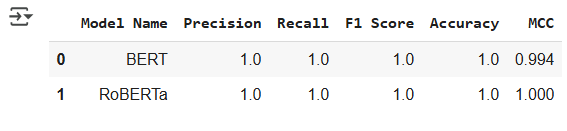

* As shown in the above figure, the evaluation metrics such as **F1 score**, **Precision**, **Recall** and even **Accuracy** of both the models is quite **similar**. So, in order to evaluate further and find out the better model **MCC** evaluation metric is used.
* **MCC (Matthews Correlation Coefficient)** is an evaluation metric used for classification models, including BERT and RoBERTa, especially in imbalanced datasets. It provides a balanced measure even when the dataset has a class imbalance.

# **1. BERT:**
* **Performance:** Achieved an MCC of 0.994. The classification report shows high precision, recall, and F1-scores across most classes.
* **Reason:** BERT is trained on a smaller datset compared to RoBerTa and it was trained for 1 million steps with 256 batch size.



# **2. RoBERTa:**

* **Performance:** Outperformed BERT with an MCC of 1.00. The classification report shows near-perfect precision, recall, and F1-scores across all classes.
* **Reason:** RoBERTa is trained on a larger dataset and it was trained for 500K more steps with larger batch sizes (up to 8K), leading to better performance.


# **Best Performing Feature Set**

* **Transformer Models (BERT and RoBERTa):** These models outperformed traditional NLP features (BoW, TF-IDF, FastText) by a significant margin. Its due to their ability to capture deep contextual relationships using self-attention mechanisms. Unlike sequential models, transformers process entire sentences at once, allowing them to understand both short-term and long-term dependencies efficiently.

# **CERTAIN CHALLENGES:**


**1. High Computational Cost:** They require powerful GPUs/TPUs for training and inference.They also need high memory and storage.

**2. Slow Training & Inference:** The training time is quite slow compared to other traditional models due to millions of parameters.

**3. Data-Hungry Models:** They need large-scale pretraining datasets for good generalization.



# **Potential Improvements and Further Experiments:**

*   Using **DistilBERT** reduces model size by 60% while retaining 97% of BERT’s accuracy shrinking storage requirements.
*   **Self-supervised** learning helps models generalize better with limited data.
* **TinyBERT** and **MobileBERT** can be used to optimize for low-end devices.

